# Catcher Pitch Framing

See this paper for a "hierarchical bayesian" approach:https://arxiv.org/abs/1704.00823

See this DataRobot blog post for a ML approach (really just logistic regression): https://blog.datarobot.com/catcher-pitch-framing-using-machine-learning-part-1

Or, the improved DataRobot model: https://blog.datarobot.com/catcher-pitch-framing-using-machine-learning-part-two

In [1]:
import csv
import requests
from bs4 import BeautifulSoup, Comment
bbref_addr = 'https://www.baseball-reference.com'

from pybaseball import statcast

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pygam import LogisticGAM

## Data and Model

The goal of this study is to build a statistical model to estimate each umpire's probability of calling a strike (adjusting for pitch participants, pitch location and contextual information like the count).  Using this model we can estimate each catcher's effect on an umpire's chance of calling a strike.  We then translate these estimated effects into average runs saved across a season.

__Methodology__

The approach we take to esimate the catcher effect is to use an iterative method to first distribute credit for a called strike among the batter, catcher, pitcher and umpire.  We will fit a statistical model of the called strike probability that accounts for the above factors.  Armed with such a model, we then estimate the predicted called strike probability with and without the catcher.  The difference in these probabilities reflects the catcher's apparent framing effect on that pitch.  Finally, we estimate the impact of framing by weighting these effects by the value of "stealing a strike" and summing over all pitches caught by a catcher.

Before beginning, let us introduce some notation.  

 - For a given taken pitch, let $y=1$ if it is called a strike and let $y = 0$ if it is called a ball.
 
 - Let $b$ , $ca$, $co$ , $p$ and $u$ be indices corresponding to the batter, catcher, count, pitcher and umpire for that pitch.
 
 - Let $x$ and $z$ be the horizontal and vertical coordinates of the pitch as it crosses the front of home plate, respectively 
 
 - To accomodate a separate model for each umpire $u$ we introduce vectors $\Theta^{u, B}$, $\Theta^{u, CA}$, $\Theta^{u, CO}$ and $\Theta^{u, P}$ to hold the _partial_ effect of each batter, catcher, count and pitcher, respectively, on umpire _u_'s likelihood to call a strike. 
 
 - For each umpire _u_, we introduce a function of pitch location $f^u(x, z)$
 
Then, at a high level, we model the log-odds of a strike call as:

\begin{equation}
\log \left( \frac{P(y = 1)}{P(y = 0)} \right) = \Theta^{u, B}_b + \Theta^{u, CA}_{ca} + \Theta^{u, CO}_{co} + \Theta^{u, P}_p + f^u(x, z)
\end{equation}

All of the models are fit in a hierarchical Bayesian framework, which provides natural uncertainty quantification for our framing estimates (this quantification is is vital considering the fact that several teams are making framing-based roster decisions).

The data we use is from the 2015-2019 seasons.  We use 2015-2017 data to select the function $f^u(x, z)$.  The data from 2018 is then used to train (and test) the strike probability model.  Finally, we make predictions on 2019 and assess the framing ability (measured in "stolen strikes" or "+Calls") and convert this ability into "runs saved."  

#### Download the Pitch-by-Pitch Data (if you haven't already)

In [ ]:
# pitch-by-pitch data
# data2010 = statcast(start_dt='2010-04-04', end_dt='2010-10-03')
# data2010.to_csv("../data/pitch_data_2010.csv", index=False)

# data2011 = statcast(start_dt='2011-03-31', end_dt='2011-09-28')
# data2011.to_csv("../data/pitch_data_2011.csv", index=False)

# data2012 = statcast(start_dt='2012-03-28', end_dt='2012-10-03')
# data2012.to_csv("../data/pitch_data_2012.csv", index=False)

# data2013 = statcast(start_dt='2013-03-31', end_dt='2013-09-30')
# data2013.to_csv("../data/pitch_data_2013.csv", index=False)

# data2014 = statcast(start_dt='2014-03-22', end_dt='2014-09-28')
# data2014.to_csv("../data/pitch_data_2014.csv", index=False)

# data2015 = statcast(start_dt='2015-04-05', end_dt='2015-10-04')
# data2015.to_csv("../data/pitch_data_2015.csv", index=False)

# data2016 = statcast(start_dt='2016-04-03', end_dt='2016-10-02')
# data2016.to_csv("../data/pitch_data_2016.csv", index=False)

# data2017 = statcast(start_dt='2017-04-02', end_dt='2017-10-01')
# data2017.to_csv("../data/pitch_data_2017.csv", index=False)

# data2018 = statcast(start_dt='2018-03-29', end_dt='2018-10-01')
# data2018.to_csv("../data/pitch_data_2018.csv", index=False)

# data2019 = statcast(start_dt='2019-03-20', end_dt='2019-08-31')
# data2019.to_csv("../data/pitch_data_2019.csv", index=False)

#### Scrape the Homeplate Umpire Data (if you haven't already)

### Statcast Data

We collected all pitch data using the pybaseball python module that allows for easy scraping of websites such as Baseball Savant, baseball-reference.com, etc.

Although we are mainly interested in studying framing effects in the 2018 season, we collected all statcast data from the 2015 to 2019 regular seasons.  We use the data from 2015-17  to select the function of pitch location $f^u(x, z)$.  We then fit the final model using the 2018 data and assess the model's predictive performance using data from 2019.

### Function to Pre-process the Data

In [2]:
# import the data for calendar year
def get_pitch_data(year):
    
    print("===================================================")
    print(f"Gathering data for {year} season")
    print("===================================================")
    print()
    
    # import the full pitch-by-pitch dataset 
    pitch_data_df = pd.read_csv(f"../data/pitch_data_{year}.csv")
    total_num_pitches = len(pitch_data_df)
    
    print(f"Number of total pitches in {year} data: {total_num_pitches}")
    print()

    # just keep the balls and called strikes
    pitch_taken = ['ball', 'called_strike']
    pitches_taken_df = pitch_data_df[pitch_data_df['description'].isin(pitch_taken)]
    num_pitches_taken = len(pitches_taken_df)

    print(f"Number of pitches taken: {num_pitches_taken}")
    print(f"Percentage of pitches taken: {round((num_pitches_taken / total_num_pitches) * 100., 2)}")
    print()

    # compute the number/percentage of taken strikes
    strikes_taken_df = pitches_taken_df[pitches_taken_df['description'] == 'called_strike']
    num_strikes_taken = len(strikes_taken_df)

    print(f"Number of strikes taken: {num_strikes_taken}")
    print(f"Percentage of pitches taken that were called strikes: {round((num_strikes_taken / num_pitches_taken) * 100., 2)}")
    print()
    
    # construct the approximate strike zone
    left_strike_boundary = -0.71
    right_strike_boundary = -left_strike_boundary

    pitches_taken_df['low_strike_boundary'] = pitches_taken_df['sz_bot']
    pitches_taken_df['high_strike_boundary'] = pitches_taken_df['sz_bot'] + pitches_taken_df['sz_top']

    bottom_strike_boundary = pitches_taken_df['low_strike_boundary'].mean()
    top_strike_boundary = pitches_taken_df['high_strike_boundary'].mean()

    print("===================================================")
    print(f"Top boundary of approximate strike zone: {round(top_strike_boundary, 2)}")
    print(f"Bottom boundary of approximate strike zone: {round(bottom_strike_boundary, 2)}")
    print(f"Right boundary of approximate strike zone: {right_strike_boundary}")
    print(f"Left boundary of approximate strike zone: {left_strike_boundary}")
    print("===================================================")
    print()
    
    # restrict ourselves to pitches that were "close enough" (i.e., within one foot of the approximate strike zone)
    pitches_taken_df = pitches_taken_df[
        (pitches_taken_df['plate_x'] >= left_strike_boundary - 1) &\
        (pitches_taken_df['plate_x'] <= right_strike_boundary + 1) &\
        (pitches_taken_df['plate_z'] <= top_strike_boundary + 1) &\
        (pitches_taken_df['plate_z'] >= bottom_strike_boundary - 1)
    ]
    num_pitches_in_zone = len(pitches_taken_df)
    
    print(f"Number of pitches within 1 foot of approximate stike zone: {num_pitches_in_zone}")
    print(f"Percentage of pitches within 1 foot of approximate strike zone: {round((num_pitches_in_zone / total_num_pitches) * 100., 2)}")
    print()
    
    # join with HP umpire dataframe (to bring in the ID of the HP umpire)
    
    # first, rename some team abbreviations to match between the two dataframes
    team_rename_dict = {'NYY': 'NYA',
                        'NYM': 'NYN', 
                        'TB': 'TBA', 
                        'CHC': 'CHN',
                        'CWS': 'CHA',
                        'KC': 'KCA',
                        'SF': 'SFN',
                        'SD': 'SDN',
                        'LAD': 'LAN',
                        'LAA': 'ANA',
                        'STL': 'SLN',
                        'WSH': 'WAS'}
    def rename_team(x):
        if x in list(team_rename_dict.keys()):
            return team_rename_dict[x]
        else:
            return x
    pitches_taken_df['home_team'] = pitches_taken_df['home_team'].apply(rename_team)
    pitches_taken_df['game_team_id'] = pitches_taken_df['home_team'] + pitches_taken_df['game_date'].str.replace('-', '')
    hp_umps = pd.read_csv(f"../data/hp_umpires_{year}.csv", header=None)
    hp_umps.columns = ['game_team_id', 'hp_umpire']
    pitches_taken_df = pd.merge(pitches_taken_df, hp_umps, how='inner', on='game_team_id')
    
    # compute the unique number of umpires/batters/catchers/pitchers in the dataset
    num_unique_umpires = len(pitches_taken_df['hp_umpire'].unique())
    num_unique_batters = len(pitches_taken_df['batter'].unique())
    num_unique_catchers = len(pitches_taken_df['fielder_2'].unique())
    num_unique_pitchers = len(pitches_taken_df['pitcher'].unique())

    print(f"Number of unique umpires: {num_unique_umpires}")
    print(f"Number of unique batters: {num_unique_batters}")
    print(f"Number of unique catchers: {num_unique_catchers}")
    print(f"Number of unique pitchers: {num_unique_pitchers}")
    print()
    print()
    
    return pitches_taken_df

### Process the Data and Print out Some Counts

In [3]:
# process the data used for f(x, z) and training the model
taken_pitches_2015_df = get_pitch_data(2015)
taken_pitches_2016_df = get_pitch_data(2016)
taken_pitches_2017_df = get_pitch_data(2017)
taken_pitches_2018_df = get_pitch_data(2018)
taken_pitches_2019_df = get_pitch_data(2019)

# put the 2015-17 data together for estimating f(x, z)
taken_pitches_2015_17_df = pd.concat([taken_pitches_2015_df, taken_pitches_2016_df, taken_pitches_2017_df])

print(f"Total pitches in data to estimate location function: {len(taken_pitches_2015_17_df)}")
print()

Gathering data for 2015 season

Number of total pitches in 2015 data: 702302

Number of pitches taken: 351121
Percentage of pitches taken: 50.0

Number of strikes taken: 118692
Percentage of pitches taken that were called strikes: 33.8

Top boundary of approximate strike zone: 5.04
Bottom boundary of approximate strike zone: 1.58
Right boundary of approximate strike zone: 0.71
Left boundary of approximate strike zone: -0.71

Number of pitches within 1 foot of approximate stike zone: 309768
Percentage of pitches within 1 foot of approximate strike zone: 44.11

Number of unique umpires: 92
Number of unique batters: 952
Number of unique catchers: 110
Number of unique pitchers: 734


Gathering data for 2016 season

Number of total pitches in 2016 data: 715823

Number of pitches taken: 360212
Percentage of pitches taken: 50.32

Number of strikes taken: 120771
Percentage of pitches taken that were called strikes: 33.53

Top boundary of approximate strike zone: 5.07
Bottom boundary of approxi

### Adjusting for Pitch Location

Here, we use data from 2015-17 to estimate the pitch location function $f^u(x, z)$.

Naively, the pitch location is the main driver of called strike probability.  The simplest way to incorporate pitch location into a _linear model_ would be to include the horizontal and vertical coordinates $(x, z)$ recorded in the statcast data as two more linear predictors in our model:

\begin{equation}
f^u(x, z) = \theta^u_x \, x + \theta^u_z \, z
\end{equation}

However, without accounting for any interaction terms, this forces an unrealistic left-to-right and top-to-bottom monotonicity in the called strike probablility surface.

Below, we compute the empirical called strike probabilities using the data from 2015-17 data and plot the probabilites as a "heat map."  For reference, we have also included the strike zone (the average of the estimated strike zone from the statcast data) as a rectangle with a dashed line as well as a solid-line rectangle which denotes the strike zone plus one inch outwards.  If the center of a pitch passes through the region bounded by the solid line, some part of the pitch passes through the estimated strike zone.  This heat map is drawn from the umpire’s perspective so right handed batters stand to the left of home plate (i.e. negative X values) and left-handed batters stand to the right (i.e. positive X values). 

#### Heat Map of Empirical Called Strike Probabilities

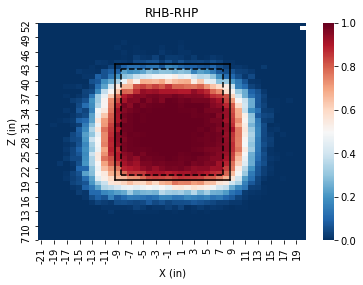

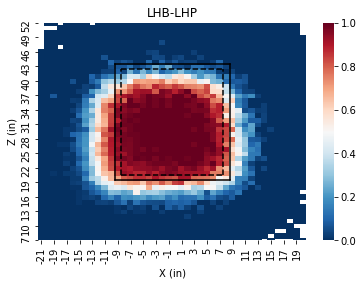

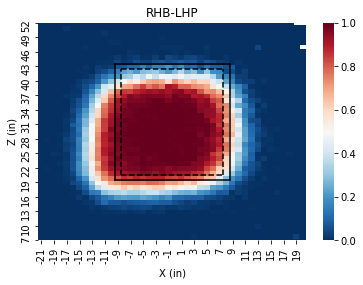

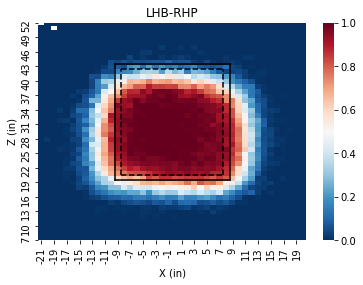

In [21]:
# function to plot called strike 
def strike_prob_plot(df, pitch_side='R', bat_side='R'):
    
    # specify the handedness of pitcher and batter
    bat_pitch_df = df[(df['p_throws'] == pitch_side) &\
                      (df['stand'] == bat_side)]

    # just keep pitch outcome and plate position
    cols_to_keep = ['description', 'plate_x', 'plate_z']
    heat_map_df = bat_pitch_df[cols_to_keep]

    # convert to inches
    heat_map_df['plate_x'] = heat_map_df['plate_x'].apply(lambda x: x * 12)
    heat_map_df['plate_z'] = heat_map_df['plate_z'].apply(lambda x: x * 12)

    # convert outcome to binary (1 = called strike, 0 = ball)
    heat_map_df['description'] = heat_map_df['description'].apply(lambda x: 1 if x == 'called_strike' else 0)

    # set limits
    heat_map_df = heat_map_df[(np.abs(heat_map_df['plate_x']) <= 22) &\
                              (heat_map_df['plate_z'] <= 55) & (heat_map_df['plate_z'] >= 6)]

    # for binning purposes, take the "floor" of x and z coordiates
    heat_map_df['plate_x'] = np.floor(heat_map_df['plate_x']).astype(int)
    heat_map_df['plate_z'] = np.floor(heat_map_df['plate_z']).astype(int)

    # compute the historical strike probability (i.e., the mean) for each cell
    temp_df = pd.DataFrame(heat_map_df.groupby(['plate_x', 'plate_z'])['description'].mean())
    temp_df.reset_index(inplace=True, drop=False)
    temp_df.columns = ['x', 'z', 'probability']
    temp_df = temp_df.pivot('z', 'x', 'probability')
    
    f, ax = plt.subplots()
    ax.plot([13, 29], [36, 36], '--k')
    ax.plot([13, 29], [14, 14], '--k')
    ax.plot([13, 13], [14, 36], '--k')
    ax.plot([29, 29], [14, 36], '--k')
    ax.plot([12, 30], [37, 37], '-k')
    ax.plot([12, 30], [13, 13], '-k')
    ax.plot([12, 12], [13, 37], '-k')
    ax.plot([30, 30], [13, 37], '-k')
    sns.heatmap(temp_df, cmap="RdBu_r")

    ax.set_ylim(reversed(plt.ylim()))
    ax.set_xlabel("X (in)")
    ax.set_ylabel("Z (in)")
    ax.set_title(f"{pitch_side}HB-{bat_side}HP")
        
# make the plots
strike_prob_plot(taken_pitches_2015_17_df, pitch_side='R', bat_side='R')
strike_prob_plot(taken_pitches_2015_17_df, pitch_side='L', bat_side='L')
strike_prob_plot(taken_pitches_2015_17_df, pitch_side='R', bat_side='L')
strike_prob_plot(taken_pitches_2015_17_df, pitch_side='L', bat_side='R')

### Spatial Distributions for Pitches Taken

Instead of specifying an explicit parameterization in terms of the horizontal and vertical coordinates, we will use a smoothed estimate of the historical log-odds of a called strike as an implicit parameterization of pitch location.

Below, we show the plots of the spatial distribution of taken pitches broken down by the batter and pitcher handedness.

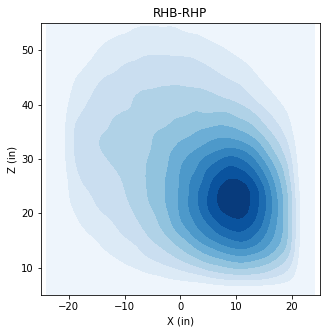

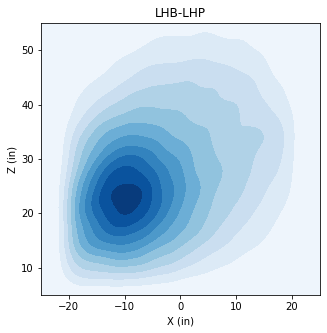

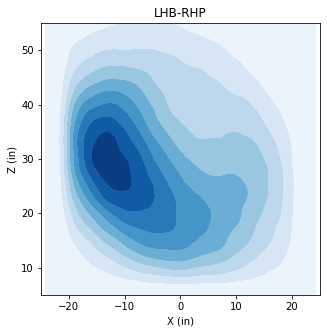

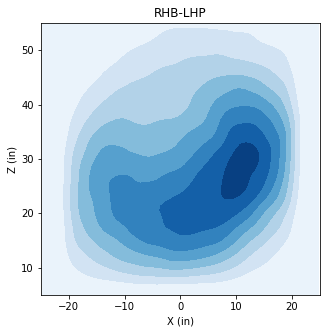

In [22]:
def pitch_location_kde_plot(df, pitch_side='R', bat_side='R'):
    
    temp_df = df[['plate_x', 'plate_z', 'p_throws', 'stand']]
    temp_df.columns = ['x', 'z', 'pitch_side', 'bat_side']
    
    temp_df = temp_df[(temp_df['pitch_side'] == pitch_side) & (temp_df['bat_side'] == bat_side)]

    # keep only the model features
    x_z_df = temp_df.drop(['pitch_side', 'bat_side'], axis=1)

    # convert coordinates to feet
    x_z_df = x_z_df * 12.
    
    # convert coordinates to lists
    x = x_z_df['x'].tolist()
    z = x_z_df['z'].tolist()
    
    # plot the kernel density estimation 
    plt.figure(figsize=(5,5))
    sns.kdeplot(x, z, cmap="Blues", shade=True, shade_lowest=True, )
    plt.xlim([-25, 25])
    plt.ylim([5, 55])
    plt.xlabel("X (in)")
    plt.ylabel("Z (in)")
    plt.title(f"{bat_side}HB-{pitch_side}HP")

# make the plots
pitch_location_kde_plot(taken_pitches_2015_17_df, pitch_side='R', bat_side='R')
pitch_location_kde_plot(taken_pitches_2015_17_df, pitch_side='L', bat_side='L')
pitch_location_kde_plot(taken_pitches_2015_17_df, pitch_side='R', bat_side='L')
pitch_location_kde_plot(taken_pitches_2015_17_df, pitch_side='L', bat_side='R')
plt.show()

Note that the spatial distribution of taken pitches varies considerably with the combination of batter and pitcher handedness.

 - When the batter and pitcher of the same handedness, we see a much higher density of "low and away" pitches 
 - In contrast, in match ups between left-handed batters and right-handed pitchers (or vice versa), we see a higher density of pitches thrown to the outside edge of the strike zone further away from the batter
 
The differences in spatial distribution of pitches seen in these match-ups motivate us to use a separate smoothed estimate of the historical log-odds of a called strike for each combination of batter and pitcher handedness.

### Fitting a Generalized Additive Model for Pitch Location

We use the aggregated data from 2015-2017 to train fit the function $f^u(x, z)$ and apply the function to the data from 2018. 

To get a baseline of how our models perform, let's first just train ONE model to obtain the $f(x, z)$ function.

In [23]:
# keep only the columns we need and rename them to more convenient names
pitch_loc_df = taken_pitches_2015_17_df[['description', 'plate_x', 'plate_z']]
pitch_loc_df.columns = ['is_strike', 'x', 'z']

# convert outcome to a boolean
pitch_loc_df['is_strike'] = pitch_loc_df['is_strike'].apply(lambda x: 1 if x == 'called_strike' else 0)

X_train = pitch_loc_df.drop(['is_strike'], axis=1)
y_train = pitch_loc_df['is_strike']

# fit an "off-the-shelf" GAM
fxz_gam = LogisticGAM().fit(X_train, y_train)

# print the summary for the model 
print(fxz_gam.summary())

# print the accruracy on the training data
print(fxz_gam.accuracy(X_train, y_train))

MemoryError: Unable to allocate array with shape (950673, 41) and data type float64

We fit generalized additive models to the data aggregated from 2015 – 2017, one for each combination of pitcher and batter handedness, hereafter referred to as the “hGAMs” or “historical GAMS.” These models express the log-odds of a called strike as a smooth function of the pitch location.

#### Fit the hGAM's 

In [ ]:
def train_model(df, pitch_side='R', bat_side='R'):

    temp_df = df[(df['pitch_side'] == pitch_side) & (df['bat_side'] == bat_side)]

    # split data into features and targets
    X_train = temp_df.drop(['is_strike', 'pitch_side', 'bat_side'], axis=1)
    y_train = temp_df['is_strike']

    # fit the "off-the-shelf" model
    gam = LogisticGAM().fit(X_train, y_train)
    
    print()
    print()
    print("==========================================")
    print(f"Summary for {bat_side}HB-{pitch_side}HP Model")
    print("==========================================")
    print()
    
    # print the summary of the model fit
    print(gam.summary())
    print()

    # print the accuracy on the training data
    print(f"{bat_side}HB-{pitch_side}HP Model accuracy: {round(gam.accuracy(X_train, y_train), 3)}")
    print()
    
    print("==========================================")
    print("==========================================")
    print()

    return gam




RHB_RHP_gam = train_model(pitch_loc_df, pitch_side='R', bat_side='R')
LHB_LHP_gam = train_model(pitch_loc_df, pitch_side='L', bat_side='L')
RHB_LHP_gam = train_model(pitch_loc_df, pitch_side='L', bat_side='R')
LHB_RHP_gam = train_model(pitch_loc_df, pitch_side='R', bat_side='L')

#### use a Kernel Density Plot to test the model on 2018 data

### One Model to Fit Them All

In [ ]:
def build_data(year):

    data = pd.read_csv(f"../data/pitch_data_{year}.csv")

    # first, rename some team abbreviations to match between the two dataframes
    team_rename_dict = {'NYY': 'NYA',
                        'NYM': 'NYN', 
                        'TB': 'TBA', 
                        'CHC': 'CHN',
                        'CWS': 'CHA',
                        'KC': 'KCA',
                        'SF': 'SFN',
                        'SD': 'SDN',
                        'LAD': 'LAN',
                        'LAA': 'ANA',
                        'STL': 'SLN',
                        'WSH': 'WAS'}
    def rename_team(x):
        if x in list(team_rename_dict.keys()):
            return team_rename_dict[x]
        else:
            return x
    data['home_team'] = data['home_team'].apply(rename_team)
    data['game_team_id'] = data['home_team'] + data['game_date'].str.replace('-', '')
    hp_umps = pd.read_csv(f"../data/hp_umpires_{year}.csv", header=None)
    hp_umps.columns = ['game_team_id', 'hp_umpire']
    data = pd.merge(data, hp_umps, how='inner', on='game_team_id')
    data.drop(['home_team', 'game_date', 'game_team_id'], axis=1, inplace=True)
    
    cols_to_keep = ['description', 'hp_umpire', 'pitcher', 'fielder_2', 'batter',
                    'release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'release_extension', 'release_spin_rate',
                    'stand', 'p_throws', 'balls', 'strikes', 'outs_when_up', 'inning', 'inning_topbot', 'on_3b', 'on_2b', 'on_1b', 
                    'bat_score', 'fld_score',
                    'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
                    ]

    data = data[cols_to_keep]
    for col in ['pitcher', 'fielder_2', 'batter', 'balls', 'strikes', 'outs_when_up', 'inning', 'bat_score', 'fld_score']:
        data = data[data[col] == data[col]]
        data[col] = data[col].astype(int)
        
    print("=====================")
    print(f"Stats for year {year}")
    print("=====================")
    print_stats(data)
    
    # first, keep only outcomes that include called_strike or ball
    data = data[(data['description'] == 'called_strike') | (data['description'] == 'ball')]

    data['called_strike'] = data['description'] == 'called_strike'

    data.drop('description', axis=1, inplace=True)
    
    data['bats_R'] = data['stand'] == 'R'

    data['throws_R'] = data['p_throws'] == 'R'

    data.drop(['stand', 'p_throws'], axis=1, inplace=True)

    for col in ['on_1b', 'on_2b', 'on_3b']:
        data[col] = data[col].apply(lambda x: x == x)
        
    data['inning_top'] = data['inning_topbot'] == 'Top'
    data.drop('inning_topbot', axis=1, inplace=True)

    # drop any rows with missing value (very small percentage)
    data.dropna(inplace=True)

    return data

In [ ]:
data2018 = build_data(2018)

X = data2018.drop(['called_strike', 'hp_umpire', 'pitcher', 'fielder_2', 'batter'], axis=1, inplace=False)
y = data2018['called_strike']

# cols_to_keep = [
#     'release_speed',
#     'release_pos_x','release_pos_y','release_pos_z',
#     'pfx_x', 'pfx_z',
#     'plate_x', 'plate_z',
#     'bats_R', 'throws_R'
# ]
# X = X[cols_to_keep]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4256)

print(f"Training dataset dimensions: {X_train.shape}")
print(f"Testing dataset dimensions: {X_test.shape}")

In [ ]:
X_train.head()